# Factorisation-aware matrix element emulator

This is a quickstart notebook that will take you through the necessary steps to reproduce the method described in the paper.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# comment this out if you want to use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
from fame.phase_space import phasespace
from fame.utilities import utility_functions, tests
from fame.data_generation import cs_dipole, model_inputs
from fame.model.dipole_model import DipoleModel

# Generate phase-space points using RAMBO with FastJet clustering

In [4]:
w = 1000 # sqrt(s)
num_jets = 4 # number of final state jets
train_points = 500000
test_points = 100000
num_points = train_points + test_points # number of phase-space points to generate
y_global_cut = 0.001 # global phase-space cut
num_cores = 16 # number of cores for parallel clustering of jets

In [5]:
# clusters points using e+e- kt algorithm
X = phasespace.generate_generic(
    num_jets,
    num_points,
    w,
    y_global_cut,
    num_cores
)

Phase-space points:   0%|          | 0/600000 [00:00<?, ?it/s]

######## Finished generating generic phase-space points #########


Phase-space points are structured in the following way:
1. First and seconds rows are e+ and e-
2. Third row is quark
3. Fourth row is anti-quark
4. Fifth and onwards are gluons

This helps us to keep consistency between the inputs we calculate.

In [6]:
X[0]

array([[ 500.        ,    0.        ,    0.        ,  500.        ],
       [ 500.        ,    0.        ,    0.        , -500.        ],
       [ 268.19993517,  -27.5631736 ,  -16.54318263,  266.26640756],
       [ 118.69287146,  -65.239343  ,  -27.94847027,  -95.13521362],
       [ 347.29117021,  124.57254434, -207.69860101, -248.90586421],
       [ 265.81602316,  -31.77002774,  252.19025391,   77.77467027]])

# Evaluate phase-space points using matrix element provider
## here we use NJet but others are available

In [7]:
njet_data, njet_order = utility_functions.run_njet(num_jets)

Check 'njet_data' has the correct incoming and outgoing particles.

'inc': [11, -11] -> e+ e-

'out': [1, -1, 21, 21, 21] -> ddxggg

In [8]:
print(njet_data[0][1])

[{'born': 0, 'inc': [11, -11], 'loop': 0, 'mcn': 1, 'name': 'eeddxGG', 'out': [1, -1, 21, 21]}]


In [9]:
Y = utility_functions.generate_LO_njet([x.tolist() for x in X], njet_data)

-------- channel eeddxGG -------- (600000 points)


  0%|          | 0/600000 [00:00<?, ?it/s]

# Split data into training and testing sets

In [10]:
X_train, X_test = X[:train_points], X[train_points:]
Y_train, Y_test = Y[:train_points], Y[train_points:]

Check magnitude of training and testing datasets are similar.

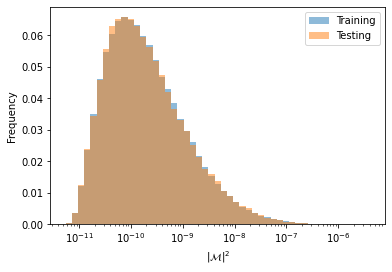

In [11]:
bins = np.logspace(np.log10(np.min(Y_train)), np.log10(np.max(Y_train)), 50)
plt.figure()
plt.hist(Y_train, bins, weights=np.ones(train_points) / train_points, alpha=0.5, label='Training')
plt.hist(Y_test, bins, weights=np.ones(test_points) / test_points, alpha=0.5, label='Testing')
plt.legend()
plt.xscale("log")
plt.xlabel(r"$|\mathcal{M}|^{2}$")
plt.ylabel("Frequency")
plt.show()

# Generate neural network inputs

## Calculate dipoles and recoil factors

First need to get relevant permutations where each permutation is in the form $(i, j, k)$

$i$ = emitter,
$j$ = emitted,
$k$ = spectator

Partons are numbered from $(1, ..., n_{j})$ where 1 = $q$, 2 = $\bar{q}$, and everything 3+ = $g$, like the phase-space points.

For example permutation $(2, 4, 1)$ would mean the anti-quark emits a gluon and the quark is the spectator.

**For each permutation we have a corresponding dipole and recoil factor.**

In [12]:
relevant_permutations = model_inputs.get_relevant_permutations(num_jets)
tests.check_relevant_permutations(relevant_permutations, num_jets)

In [13]:
relevant_permutations

[(1, 3, 2),
 (1, 3, 4),
 (1, 4, 2),
 (1, 4, 3),
 (2, 3, 1),
 (2, 3, 4),
 (2, 4, 1),
 (2, 4, 3),
 (3, 4, 1),
 (3, 4, 2)]

In [14]:
# initialise classes that will generate inputs
CS = cs_dipole.CS_dipole(mode='gluon')
relevant_inputs = model_inputs.ModelInputsGenerator(relevant_permutations, CS)

If there are two or more gluons in the final state we need to account for spin-correlation effects that have been averaged out in the spin-averaged Catani-Seymour dipoles.

**For each pair of gluons in the final state, $(i, j)$, there are $sin(2\phi_{ij})$ and $cos(2\phi_{ij})$ terms.**

**The total set of dipoles is therefore the Catani-Seymour dipoles and the spin-correlation terms.**

In [15]:
# calculate model inputs
if num_jets > 3:
    # extra spin-correlation terms
    train_phi_terms = model_inputs.calculate_cs_phis(p=X_train, num_jets=num_jets, cast=False)
    tests.check_phi_terms(train_phi_terms, num_jets)
    
    # Catani-Seymour dipoles and recoil factors
    # concatenate phi terms with Catani-Seymour dipoles
    train_dipoles, train_ys = relevant_inputs.calculate_inputs(
        p_array=X_train,
        to_concat=[*train_phi_terms]
    )
    
    tests.check_recoil_factors(train_ys, num_jets)
    tests.check_all_dipoles(train_dipoles, num_jets)
else:
    # no phi terms for 3-jet case
    train_dipoles, train_ys = relevant_inputs.calculate_inputs(p_array=X_train)
    tests.check_all_dipoles(train_dipoles, num_jets)

In [16]:
# set scales of problem
pred_scale = np.min(Y_train)
dipole_scale = np.mean(train_dipoles)
coef_scale = pred_scale / dipole_scale

In [17]:
print(f"X shape = {X_train.shape}, Y shape = {Y_train.shape}, dipoles shape = {train_dipoles.shape}, ys shape = {train_ys.shape}")
print(f"pred_scale = {pred_scale}, dipole_scale = {dipole_scale}, coef_scale = {coef_scale}")

X shape = (500000, 6, 4), Y shape = (500000,), dipoles shape = (500000, 12), ys shape = (500000, 10)
pred_scale = 5.5057297814751424e-12, dipole_scale = 0.0006558569568096939, coef_scale = 8.394711261822763e-09


Now we have all the inputs generated we feed it to our emulator.

# Constructing neural network

## Define neural network hyperparameters

In [18]:
batch_size = 4096
lr = 0.001
# min_delta for EarlyStopping, should go smaller for lower multiplicity as higher accuracy there
min_delta = 1E-6
# J is tuned manually such that f_pen << mse
J = 1E6

## Initialise class for building dipole NN

In [19]:
dipole_model = DipoleModel(
    num_jets=num_jets,
    permutations=relevant_permutations,
    X=X_train,
    Y=Y_train,
    recoil_factors=train_ys,
    dipoles=train_dipoles,
    pred_scale=pred_scale,
    coef_scale=coef_scale,
    J=J
)

## Preprocesssing inputs involves standardising inputs and outputs

In [20]:
dipole_model.preprocess_inputs()

All scalers can be accessed through the DipoleModel class.

In [22]:
dipole_model.y_scaler.variables

[<tf.Variable 'mean:0' shape=(1,) dtype=float32, numpy=array([4.296902], dtype=float32)>,
 <tf.Variable 'variance:0' shape=(1,) dtype=float32, numpy=array([3.103604], dtype=float32)>,
 <tf.Variable 'count:0' shape=() dtype=int64, numpy=500000>]

## Building model: create densely connected neural network with custom loss

In [23]:
dipole_model.build_model()

In [24]:
dipole_model.model.summary()

Model: "dipole_4_jets"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4)]       0                                            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 4, 4)         9           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 16)           0           normalization[0][0]              
______________________________________________________________________________________

# Train model

The following wrapper functions will train the network until the desired min_delta is reached in the validation loss.

It is possible to terminate training prematurely by interrupting the Jupyter kernel. The model will have the most up-to-date weights.

In [25]:
history = dipole_model.train_model(
    checkpoint_path=None,
    batch_size=batch_size,
    learning_rate=lr,
    min_delta=min_delta
)

Epoch 1/10000
98/98 [==============================] - 5s 38ms/step - loss: 0.3393 - mse: 0.3393 - f_pen: 1.0352e-06 - val_loss: 0.0663 - val_mse: 0.0663 - val_f_pen: 7.8489e-07
Epoch 2/10000
98/98 [==============================] - 4s 38ms/step - loss: 0.0389 - mse: 0.0389 - f_pen: 6.6785e-07 - val_loss: 0.0216 - val_mse: 0.0216 - val_f_pen: 5.9924e-07
Epoch 3/10000
98/98 [==============================] - 4s 38ms/step - loss: 0.0150 - mse: 0.0150 - f_pen: 5.7138e-07 - val_loss: 0.0105 - val_mse: 0.0105 - val_f_pen: 5.4679e-07
Epoch 4/10000
98/98 [==============================] - 4s 39ms/step - loss: 0.0086 - mse: 0.0086 - f_pen: 5.3845e-07 - val_loss: 0.0069 - val_mse: 0.0069 - val_f_pen: 5.2210e-07
Epoch 5/10000
98/98 [==============================] - 4s 37ms/step - loss: 0.0059 - mse: 0.0059 - f_pen: 5.1937e-07 - val_loss: 0.0049 - val_mse: 0.0049 - val_f_pen: 5.1223e-07
Epoch 6/10000
98/98 [==============================] - 4s 37ms/step - loss: 0.0047 - mse: 0.0047 - f_pen: 5.04

98/98 [==============================] - 4s 36ms/step - loss: 5.2722e-04 - mse: 5.2664e-04 - f_pen: 5.8379e-07 - val_loss: 2.2813e-04 - val_mse: 2.2754e-04 - val_f_pen: 5.8991e-07
Epoch 45/10000
98/98 [==============================] - 4s 36ms/step - loss: 3.2864e-04 - mse: 3.2806e-04 - f_pen: 5.8655e-07 - val_loss: 2.2614e-04 - val_mse: 2.2555e-04 - val_f_pen: 5.8736e-07
Epoch 46/10000
98/98 [==============================] - 4s 36ms/step - loss: 4.4654e-04 - mse: 4.4595e-04 - f_pen: 5.9160e-07 - val_loss: 2.4126e-04 - val_mse: 2.4066e-04 - val_f_pen: 5.9812e-07
Epoch 47/10000
98/98 [==============================] - 4s 37ms/step - loss: 4.5145e-04 - mse: 4.5085e-04 - f_pen: 5.9488e-07 - val_loss: 2.4082e-04 - val_mse: 2.4022e-04 - val_f_pen: 6.0233e-07
Epoch 48/10000
98/98 [==============================] - 4s 37ms/step - loss: 3.9464e-04 - mse: 3.9404e-04 - f_pen: 6.0116e-07 - val_loss: 4.0045e-04 - val_mse: 3.9984e-04 - val_f_pen: 6.1015e-07
Epoch 49/10000
98/98 [==================

98/98 [==============================] - 4s 36ms/step - loss: 3.1902e-04 - mse: 3.1826e-04 - f_pen: 7.6387e-07 - val_loss: 1.3529e-04 - val_mse: 1.3452e-04 - val_f_pen: 7.6566e-07
Epoch 87/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.7933e-04 - mse: 2.7856e-04 - f_pen: 7.7467e-07 - val_loss: 1.1617e-04 - val_mse: 1.1539e-04 - val_f_pen: 7.7327e-07
Epoch 88/10000
98/98 [==============================] - 4s 37ms/step - loss: 3.1582e-04 - mse: 3.1504e-04 - f_pen: 7.7590e-07 - val_loss: 1.5700e-04 - val_mse: 1.5622e-04 - val_f_pen: 7.7552e-07
Epoch 89/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.9597e-04 - mse: 2.9519e-04 - f_pen: 7.8644e-07 - val_loss: 1.7611e-04 - val_mse: 1.7533e-04 - val_f_pen: 7.8106e-07
Epoch 90/10000
98/98 [==============================] - 4s 37ms/step - loss: 3.0041e-04 - mse: 2.9962e-04 - f_pen: 7.8728e-07 - val_loss: 6.9544e-04 - val_mse: 6.9464e-04 - val_f_pen: 7.9961e-07
Epoch 91/10000
98/98 [==================

98/98 [==============================] - 4s 36ms/step - loss: 5.0640e-05 - mse: 4.9711e-05 - f_pen: 9.2948e-07 - val_loss: 4.6286e-05 - val_mse: 4.5355e-05 - val_f_pen: 9.3098e-07
Epoch 128/10000
98/98 [==============================] - 4s 37ms/step - loss: 8.1357e-05 - mse: 8.0426e-05 - f_pen: 9.3040e-07 - val_loss: 6.3887e-05 - val_mse: 6.2957e-05 - val_f_pen: 9.2976e-07
Epoch 129/10000
98/98 [==============================] - 4s 36ms/step - loss: 1.2963e-04 - mse: 1.2870e-04 - f_pen: 9.2828e-07 - val_loss: 1.5518e-04 - val_mse: 1.5425e-04 - val_f_pen: 9.3036e-07
Epoch 130/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.4763e-04 - mse: 1.4671e-04 - f_pen: 9.2541e-07 - val_loss: 4.9366e-05 - val_mse: 4.8438e-05 - val_f_pen: 9.2827e-07
Epoch 131/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.0162e-04 - mse: 1.0069e-04 - f_pen: 9.3030e-07 - val_loss: 7.9160e-05 - val_mse: 7.8220e-05 - val_f_pen: 9.3976e-07
Epoch 132/10000
98/98 [=============

98/98 [==============================] - 4s 37ms/step - loss: 6.8128e-05 - mse: 6.7147e-05 - f_pen: 9.8112e-07 - val_loss: 4.7337e-05 - val_mse: 4.6357e-05 - val_f_pen: 9.8048e-07
Epoch 169/10000
98/98 [==============================] - 4s 37ms/step - loss: 9.7960e-05 - mse: 9.6970e-05 - f_pen: 9.9048e-07 - val_loss: 4.1499e-05 - val_mse: 4.0510e-05 - val_f_pen: 9.8959e-07

Epoch 00169: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.
Epoch 170/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.2881e-05 - mse: 2.1894e-05 - f_pen: 9.8652e-07 - val_loss: 2.6767e-05 - val_mse: 2.5780e-05 - val_f_pen: 9.8782e-07
Epoch 171/10000
98/98 [==============================] - 4s 36ms/step - loss: 2.0315e-05 - mse: 1.9330e-05 - f_pen: 9.8555e-07 - val_loss: 2.6634e-05 - val_mse: 2.5650e-05 - val_f_pen: 9.8425e-07
Epoch 172/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.0754e-05 - mse: 1.9769e-05 - f_pen: 9.8472e-07 - val_loss: 2.7777e-05 

98/98 [==============================] - 3s 35ms/step - loss: 5.3607e-05 - mse: 5.2615e-05 - f_pen: 9.9213e-07 - val_loss: 2.5110e-05 - val_mse: 2.4116e-05 - val_f_pen: 9.9395e-07
Epoch 210/10000
98/98 [==============================] - 4s 36ms/step - loss: 2.8285e-05 - mse: 2.7294e-05 - f_pen: 9.9189e-07 - val_loss: 4.5347e-05 - val_mse: 4.4353e-05 - val_f_pen: 9.9415e-07
Epoch 211/10000
98/98 [==============================] - 4s 37ms/step - loss: 3.8487e-05 - mse: 3.7496e-05 - f_pen: 9.9024e-07 - val_loss: 2.2601e-05 - val_mse: 2.1607e-05 - val_f_pen: 9.9374e-07
Epoch 212/10000
98/98 [==============================] - 4s 37ms/step - loss: 4.9589e-05 - mse: 4.8598e-05 - f_pen: 9.9048e-07 - val_loss: 2.7420e-05 - val_mse: 2.6425e-05 - val_f_pen: 9.9474e-07
Epoch 213/10000
98/98 [==============================] - 4s 36ms/step - loss: 3.6630e-05 - mse: 3.5639e-05 - f_pen: 9.9089e-07 - val_loss: 2.3609e-05 - val_mse: 2.2614e-05 - val_f_pen: 9.9421e-07
Epoch 214/10000
98/98 [=============

98/98 [==============================] - 4s 37ms/step - loss: 1.8680e-05 - mse: 1.7692e-05 - f_pen: 9.8834e-07 - val_loss: 1.9684e-05 - val_mse: 1.8697e-05 - val_f_pen: 9.8674e-07
Epoch 251/10000
98/98 [==============================] - 4s 36ms/step - loss: 2.5193e-05 - mse: 2.4204e-05 - f_pen: 9.8851e-07 - val_loss: 1.7202e-05 - val_mse: 1.6211e-05 - val_f_pen: 9.9050e-07
Epoch 252/10000
98/98 [==============================] - 4s 36ms/step - loss: 2.5047e-05 - mse: 2.4058e-05 - f_pen: 9.8841e-07 - val_loss: 2.5669e-05 - val_mse: 2.4682e-05 - val_f_pen: 9.8620e-07
Epoch 253/10000
98/98 [==============================] - 4s 36ms/step - loss: 2.9109e-05 - mse: 2.8122e-05 - f_pen: 9.8713e-07 - val_loss: 1.7458e-05 - val_mse: 1.6467e-05 - val_f_pen: 9.9119e-07
Epoch 254/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.5510e-05 - mse: 1.4521e-05 - f_pen: 9.8893e-07 - val_loss: 1.9348e-05 - val_mse: 1.8358e-05 - val_f_pen: 9.9018e-07
Epoch 255/10000
98/98 [=============

Epoch 292/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.6651e-05 - mse: 1.5666e-05 - f_pen: 9.8425e-07 - val_loss: 1.7145e-05 - val_mse: 1.6158e-05 - val_f_pen: 9.8675e-07
Epoch 293/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.2801e-05 - mse: 2.1816e-05 - f_pen: 9.8498e-07 - val_loss: 1.8182e-05 - val_mse: 1.7194e-05 - val_f_pen: 9.8736e-07
Epoch 294/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.8791e-05 - mse: 1.7806e-05 - f_pen: 9.8495e-07 - val_loss: 1.6642e-05 - val_mse: 1.5656e-05 - val_f_pen: 9.8575e-07
Epoch 295/10000
98/98 [==============================] - 4s 36ms/step - loss: 2.4883e-05 - mse: 2.3899e-05 - f_pen: 9.8403e-07 - val_loss: 1.5171e-05 - val_mse: 1.4185e-05 - val_f_pen: 9.8566e-07
Epoch 296/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.7784e-05 - mse: 1.6800e-05 - f_pen: 9.8411e-07 - val_loss: 1.4214e-05 - val_mse: 1.3228e-05 - val_f_pen: 9.8559e-07
Epoch 297/10000
98/9

Epoch 334/10000
98/98 [==============================] - 4s 36ms/step - loss: 2.3466e-05 - mse: 2.2485e-05 - f_pen: 9.8133e-07 - val_loss: 1.3474e-05 - val_mse: 1.2490e-05 - val_f_pen: 9.8409e-07
Epoch 335/10000
98/98 [==============================] - 3s 36ms/step - loss: 1.6876e-05 - mse: 1.5895e-05 - f_pen: 9.8086e-07 - val_loss: 1.4687e-05 - val_mse: 1.3706e-05 - val_f_pen: 9.8169e-07
Epoch 336/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.7979e-05 - mse: 1.6998e-05 - f_pen: 9.8078e-07 - val_loss: 1.3098e-05 - val_mse: 1.2117e-05 - val_f_pen: 9.8107e-07
Epoch 337/10000
98/98 [==============================] - 4s 37ms/step - loss: 1.8883e-05 - mse: 1.7901e-05 - f_pen: 9.8129e-07 - val_loss: 1.4137e-05 - val_mse: 1.3154e-05 - val_f_pen: 9.8215e-07
Epoch 338/10000
98/98 [==============================] - 4s 37ms/step - loss: 2.1862e-05 - mse: 2.0880e-05 - f_pen: 9.8119e-07 - val_loss: 1.5437e-05 - val_mse: 1.4455e-05 - val_f_pen: 9.8181e-07
Epoch 339/10000
98/9

# Testing model

Predict on testing phase-space points generated earlier.

This function will automatically calculate all the required dipoles and recoil factors to do the inference.

In [26]:
coefs, test_dipoles, y_preds = dipole_model.dipole_network_predictor(
    model=dipole_model.model,
    inputs=relevant_inputs,
    momenta=X_test,
    batch_size=2**16 # try increasing batch size to infer on more points at once
)

2/2 [==============================] - 1s 116ms/step


Here we provide a simple plotting function that plots the error distributions in absolute percentage difference and as a prediction-to-truth ratio.

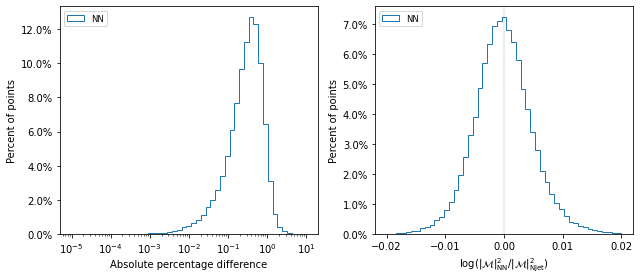

In [27]:
utility_functions.plot_diffs(Y_test, {"NN": y_preds}, bins=np.linspace(-0.02, 0.02, 50));